# Introduction

.. index:: Equations; Laplace

## A Laplace problem

As an introduction we will solve
\begin{equation}
-\triangle u + u = f
\end{equation}
in $\Omega=[0,1]^2$, where $f=f(x)$ is a given forcing term.
On the boundary we prescribe Neumann boundary
$\nabla u\cdot n = 0$.

We will solve this problem in variational form
$a(u,v) = l(v)$ with
\begin{equation}
a(u,v) := \int_\Omega \nabla u\cdot\nabla v + uv~,\qquad
l(v) := \int_\Omega fv~.
\end{equation}
We choose $f=(8\pi^2+1)\cos(2\pi x_1)\cos(2\pi x_2)$
so that the exact solution is
\begin{align*}
u(x) = \cos(2\pi x_1)\cos(2\pi x_2)
\end{align*}

We first need to setup a tessellation of $\Omega$. We use a Cartesian
grid with a 20 cells in each coordinate direction

In [1]:
import numpy as np

from dune.grid import structuredGrid
gridView = structuredGrid([0, 0], [1, 1], [20, 20])

Next we define a linear Lagrange Finite-Element space over that grid
and setup a discrete function which we will store the discrete solution
to our PDE

In [2]:
from dune.fem.space import lagrange
space = lagrange(gridView, order=1)
u_h   = space.interpolate(0, name='u_h')

We define the mathematical problem using ufl

In [3]:
from ufl import (TestFunction, TrialFunction, SpatialCoordinate,
                 dx, grad, inner, dot, sin, cos, pi )
x = SpatialCoordinate(space)
u = TrialFunction(space)
v = TestFunction(space)

f = (8*pi**2+1) * cos(2*pi*x[0])*cos(2*pi*x[1])
a = ( inner(grad(u),grad(v)) + u*v ) * dx
l = f*v * dx

Now we can assemble the matrix and the right hand side

In [4]:
from dune.fem import assemble
mat,rhs = assemble(a==l)

We solve the resulting linear system of equations $Ay=b$ using scipy.
To this end it is straightforward to expose the underlying data
structures in $A,b,u_h$ using the ``as_numpy`` attribute.
More details on how to use
[Scipy and also PetSC4py](solvers_nb.ipynb) will be discussed later
in the tutorial.

In [5]:
from scipy.sparse.linalg import spsolve as solver

A = mat.as_numpy
b = rhs.as_numpy
y = u_h.as_numpy
y[:] = solver(A,b)

Note the ``y[:]`` which guarantees that the result from the solver is
stored in the same buffer used for the discrete function. Consequently,
no copying is required.

So that's it - to see the result we plot it using matplotlib

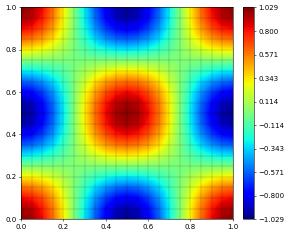

In [6]:
u_h.plot()

Since in this case the exact solution is known,
we can also compute the $L^2$ and $H^1$ errors to see how good our
approximation actually is

In [7]:
from dune.fem.function import integrate
exact = cos(2*pi*x[0])*cos(2*pi*x[1])
e_h = u_h-exact
squaredErrors = integrate(gridView, [e_h**2,inner(grad(e_h),grad(e_h))], order=5)
print("L^2 and H^1 errors:",[np.sqrt(e) for e in squaredErrors])

L^2 and H^1 errors: [0.00481699658937062, 0.4026000450756809]


<div class="alert alert-block alert-info">
<b>Note:</b>
using the assemble function with 'a==l' and 'a-l==0' produces the same result.
</div>

.. index:: Equations; Boundary value problem

## Laplace equation with Dirichlet boundary conditions
We consider the scalar boundary value problem
\begin{align*}
-\triangle u &= f & \text{in}\;\Omega:=(0,1)^2 \\
\nabla u\cdot n &= g_N & \text{on}\;\Gamma_N \\
u &= g_D & \text{on}\;\Gamma_D
\end{align*}
and $f=f(x)$ is some forcing term.
For the boundary conditions we set $\Gamma_D={0}\times[0,1]$ and take
$\Gamma_N$ to be the remaining boundary of $\Omega$.

We will solve this problem in variational form
\begin{align*}
\int \nabla u \cdot \nabla \varphi \
- \int_{\Omega} f(x) \varphi\ dx
- \int_{\Gamma_N} g_N(x) v\ ds
= 0.
\end{align*}
We choose $f,g_N,g_D$ so that the exact solution is
\begin{align*}
u(x) = \left(\frac{1}{2}(x_1^2 + x_2^2) - \frac{1}{3}(x_1^3 - x_2^3)\right) + 1~.
\end{align*}
Note: [in a later section](boundary_nb.ipynb) we discuss more general boundary
conditions.

The setup of the model using ufl is very similar to the previous example
but we need to include the non trivial Neumann boundary conditions:

In [8]:
from ufl import conditional, FacetNormal, ds, div

exact = 1/2*(x[0]**2+x[1]**2) - 1/3*(x[0]**3 - x[1]**3) + 1
a   = dot(grad(u), grad(v)) * dx
f   = -div( grad(exact) )
g_N = grad(exact)
n   = FacetNormal(space)
l   = f*v*dx + dot(g_N,n)*conditional(x[0]>=1e-8,1,0)*v*ds

With the model described as a ufl form, we can again assemble the system
matrix and right hand side using ``dune.fem.assemble``. To take the
Dirichlet boundary conditions into account we construct an instance of
``dune.ufl.DirichletBC`` that described the values to use and the part
of the boundary to apply them to. This is then passed into the
``assemble`` function:

In [9]:
from dune.ufl import DirichletBC
dbc = DirichletBC(space,exact,x[0]<=1e-8)
mat,rhs = assemble([a==l,dbc])

Solving the linear system of equations, plotting the solution, and
computing the error is now identical to the previous example:

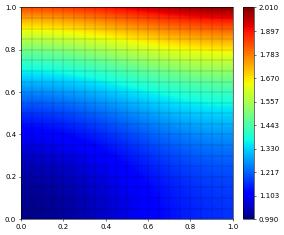

L^2 and H^1 errors: [0.0004929215389252552, 0.031176023550870714]


In [10]:
u_h.as_numpy[:] = solver(mat.as_numpy, rhs.as_numpy)
u_h.plot()
e_h = u_h-exact
squaredErrors = integrate(gridView, [e_h**2,inner(grad(e_h),grad(e_h))], order=5)
print("L^2 and H^1 errors:",[np.sqrt(e) for e in squaredErrors])

It is straightforward to solve a problem with a different right hand side
and different boundary values. Assuming the type of the boundary
conditions remains the same, the system matrix does not change we
only need to reassemble the right hand side:

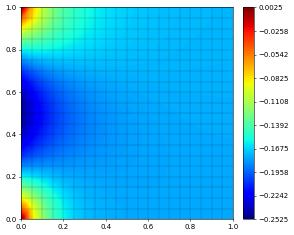

In [11]:
l   = conditional(dot(x,x)<0.1,1,0)*v*dx
dbc = DirichletBC(space,x[1]*(1-x[1]),x[0]<=1e-8)
rhs = assemble([l,dbc])
u_h.as_numpy[:] = solver(mat.as_numpy, rhs.as_numpy)
u_h.plot()

## A non-linear elliptic problem
.. index:: Equations; Non-linear elliptic

It is very easy to solve a non-linear elliptic problem with very few
changes to the above code.
We will demonstrate this using the PDE
\begin{equation}
-\triangle u + m(u) = f
\end{equation}
in $\Omega=[0,1]^2$, where again $f=f(x)$ is a given forcing term
and $m=m(u)$ is some non-linearity.
On the boundary we still prescribe Neumann boundary
$\nabla u\cdot n = 0$.

We will solve this problem in variational form
\begin{equation}
\int_\Omega \nabla u\cdot\nabla v + m(u)v = \int_\Omega fv~.
\end{equation}
We keep the same forcing $f(x)=|x|^2$ as before and choose
$m(u) = (1+u)^2u$.
Most of the code is identical to the linear case, we can use the same
grid, discrete lagrange space, and the discrete function ``u_h``.
The model description using ufl is also very similar

In [12]:
a = ( inner(grad(u),grad(v)) + (1+u)**2*u*v ) * dx
l = dot(x,x)*v * dx

To solve the non-linear problem we need to use something like a Newton
solver. We could use
[the implementation available in Scipy](solvers_nb.ipynb)
but ``dune-fem`` provides so called ``schemes`` that have a ``solve`` method
which can handle both linear and non-linear models. The default method is
a Newton-Krylov solver using a ``gmres`` method to solve the intermediate
linear problems. Since the problem here is symmetric we can use a ``cg``
method. A full list of available solvers, preconditioners, and how
to customize them is available
[here](solvers_nb.ipynb#Available-solvers-and-parameters)

In [13]:
from dune.fem.scheme import galerkin as solutionScheme
scheme = solutionScheme(a == l, solver='cg')
u_h.clear() # set u_h to zero as initial guess for the Newton solver
info = scheme.solve(target=u_h)

That's it - we can plot the solution again - we don't know the exact
solution so we can't compute any errors in this case.
In addition the ``info`` structured returned by the ``solve`` method
gives some information on the solver step

{'converged': True, 'iterations': 5, 'linear_iterations': 250, 'timing': [0.006527126, 0.003058281, 0.0034688450000000003]}


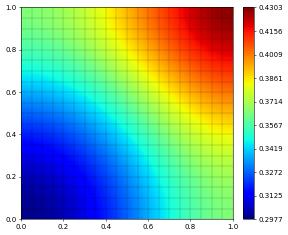

In [14]:
print(info)
u_h.plot()

A wide range of problems a covered in the
[further examples](furtherexamples.rst) section.
In the [next section](concepts_nb.ipynb) we explain the main concepts
we use to solve PDE using finite-element approximations which we end with
a solution to a non-linear time-dependent problem using the
Crank-Nicolson method in time.